<a href="https://colab.research.google.com/github/aligtr/ml/blob/master/Lab3_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#настройка среды

In [102]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#загрузка данных 

In [103]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
df = pd.read_csv(URL)

#базовый анализ данных

исключим из данных имдентификаторы, имена и номера билетов.
в имеющихся данных заполним пропуски.

In [104]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Pclass','Age', 'Fare','SibSp',	'Parch']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)

print(type(X_data))
print(X_data.shape)

<class 'numpy.ndarray'>
(891, 10)


#разбиение на обучающую/тестовую выборки

In [105]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

#функции оценки моделей

In [106]:

from sklearn.metrics import f1_score


#оценка важности признаков

In [107]:
def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# модели без нормалзации

модель дерева

f1_score=0.7200000000000001
Feature: Sex_female | 0.5713000294628707
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.2632878756943254
Feature: Age | 0.08967439414171541
Feature: Fare | 0.05504374990907275
Feature: SibSp | 0.02069395079201579
Feature: Parch | 0.0


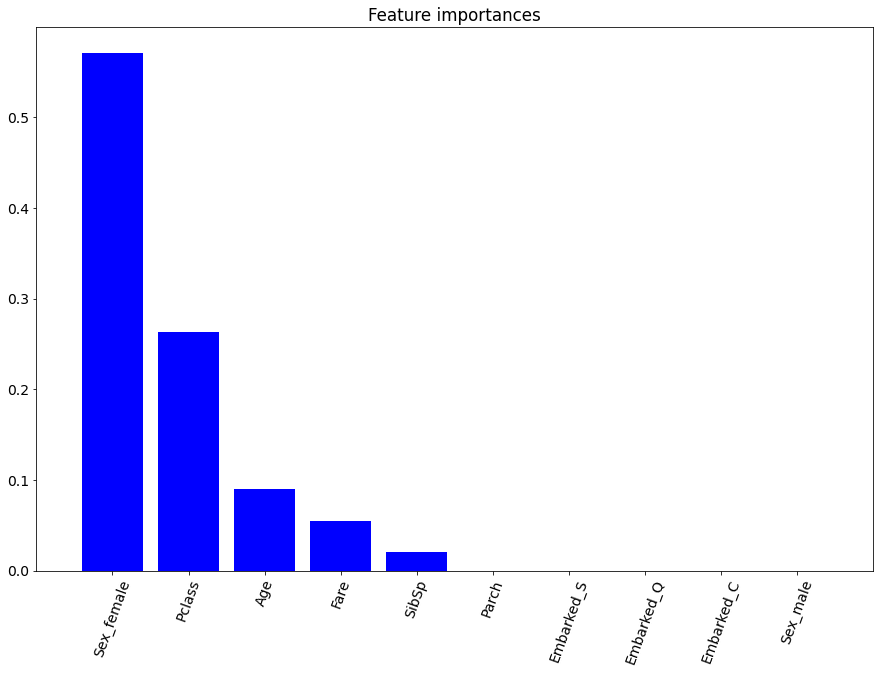

In [108]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=42,max_depth=3,criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

модель линейной регрессии

In [109]:
from sklearn.linear_model import LinearRegression

# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train, y_train)
y_pred=np.round(reg.predict(X_test))
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7384615384615385


до нормализации модель ленейной регрессии имела лучшую f1 оценку. Наиболее важными признаками оказались пол, возраст, класс, и стоимость билета.

#модели с нормализацией

In [110]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reg = LinearRegression()
# "Обучение" трансформера - определение параметров средних и отклонений
scaler.fit(X_train)

# Стандартизация данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

модель дерева

f1_score=0.7200000000000001
Feature: Sex_female | 0.5713000294628707
Feature: Sex_male | 0.0
Feature: Embarked_C | 0.0
Feature: Embarked_Q | 0.0
Feature: Embarked_S | 0.0
Feature: Pclass | 0.2632878756943254
Feature: Age | 0.08967439414171541
Feature: Fare | 0.05504374990907275
Feature: SibSp | 0.02069395079201579
Feature: Parch | 0.0


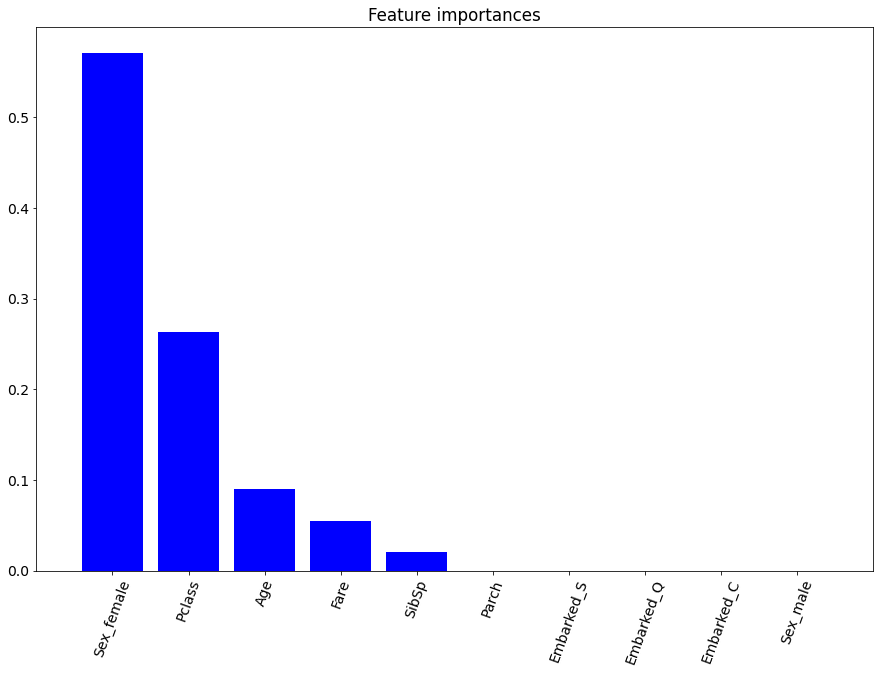

In [111]:
tree = DecisionTreeClassifier(random_state=42,max_depth=3,criterion='entropy')
tree.fit(X_train_scaled, y_train)
y_pred=tree.predict(X_test_scaled)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(tree, recovered_feat_names, X_train_scaled)

модель линейной регрессиии

In [112]:
# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train_scaled, y_train)
y_pred=np.round(reg.predict(X_test_scaled))
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7039999999999998


после нормализации предсказания модели линейной регрессии ухудшились. У модели дерева оценка не изменилась.

#определение параметров дерева

In [113]:
from sklearn.model_selection import cross_val_score
f1_scores=np.ndarray([14,2])
criterions={"gini", "entropy"}
max_depths=np.array(range(1,15,1))
for i, max_depth in enumerate(max_depths):
  for j, criterion in enumerate(criterions):
    tree = DecisionTreeClassifier(random_state=42,max_depth=max_depth,criterion=criterion)
    scores = cross_val_score(
      tree,     # Модель для оценки
      X_data,          # Данные для обучения
      y_data,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
    )
    f1_scores[i,j]=scores.mean();
table=pd.DataFrame(data=f1_scores,columns=criterions,index=max_depths)
table

,gini,entropy
1,0.770358,0.770358
2,0.740627,0.740627
3,0.789666,0.798474
4,0.778416,0.778904
5,0.793978,0.791622
6,0.796681,0.778847
7,0.791572,0.792793
8,0.793954,0.793234
9,0.793432,0.794862
10,0.794543,0.787982


в результате определения гипперпараметров: максимальная глубина дерева 3, категория entropy.

#создание новых признаков

In [114]:
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
isAlone=list();
for pers in df['FamilySize']:
  if pers==1: isAlone.append(1);
  else: isAlone.append(0);
df['isAlone'] = isAlone
df['FarePerPerson'] = df['FamilySize']/df['Fare']

оценка их важности

в результате оценки влияния добавления разных новых признаков выяснилось, что наиболее важными будут следующие: 'Sex','Pclass','Age', 'Fare','FamilySize'

f1_score=0.7200000000000001
Feature: Sex_female | 0.5693649875674883
Feature: Sex_male | 0.0
Feature: Pclass | 0.2623960972176224
Feature: Age | 0.08937065932522958
Feature: Fare | 0.017547499612378704
Feature: FamilySize | 0.06132075627728098


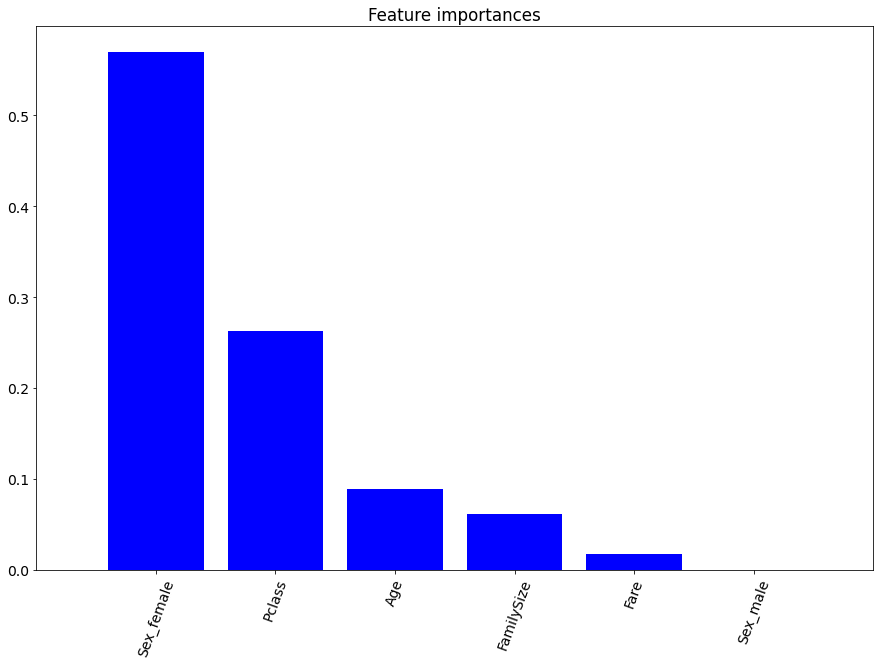

In [115]:
categorical_features = ['Sex']#, 'Embarked'
numeric_features = ['Pclass','Age', 'Fare','FamilySize']#'SibSp',	'Parch','isAlone'
# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)
preprocessor.fit(df)
X_data = preprocessor.transform(df)
TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
tree = DecisionTreeClassifier(random_state=42,max_depth=3,criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(tree, recovered_feat_names, X_train)

добывим группировку признаков age и fare

In [116]:
from sklearn.preprocessing import KBinsDiscretizer
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

df_enc = pd.DataFrame(X_data, columns=recovered_feat_names)
discr1 = KBinsDiscretizer(
    # Количество бинов    
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
df_enc['Fare'] = discr1.fit_transform(df_enc[['Fare']])
discr2 = KBinsDiscretizer(
    # Количество бинов    
    n_bins=10,
    # Способ кодирования - порядковый
    encode='ordinal',
)

# Двойные скобки для передачи DataFrame (2D данные)
df_enc['Age'] = discr2.fit_transform(df_enc[['Age']])


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


f1_score=0.7301587301587301
Feature: Sex_female | 0.6151718074311925
Feature: Sex_male | 0.0
Feature: Pclass | 0.20219648125470416
Feature: Age | 0.025741788537564533
Feature: Fare | 0.08182616628929273
Feature: FamilySize | 0.07506375648724622


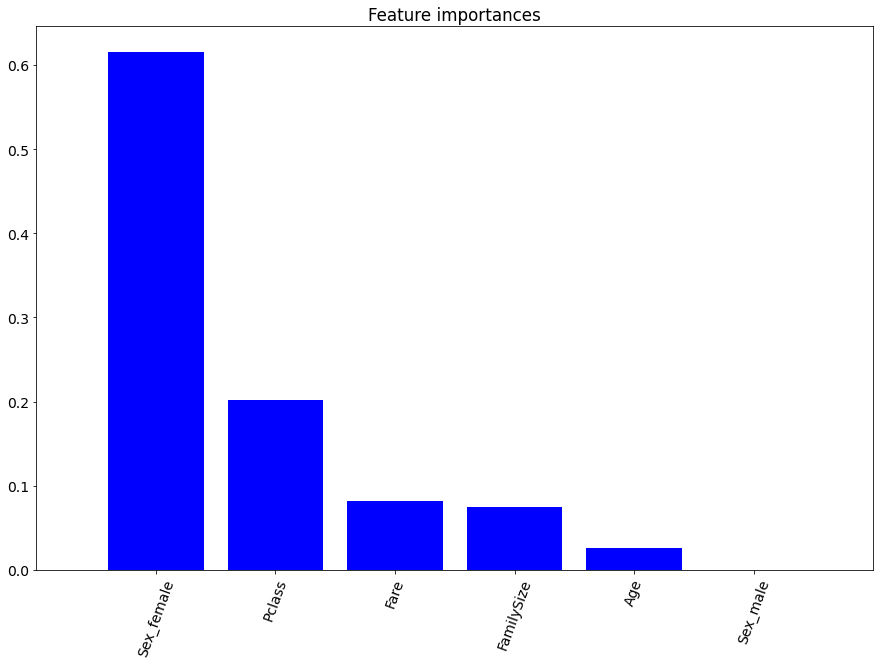

In [117]:
TRAIN_RATIO = 0.8

y_data = df['Survived']
feature_names=df_enc.columns
X_data=df_enc[feature_names]
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
tree = DecisionTreeClassifier(random_state=42,max_depth=3,criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(tree, recovered_feat_names, X_train)

замена возраста и стоимости билетов соответствующими группами позволило улучшить оценку.

#модель леса

f1_score=0.7301587301587301
Feature: Sex_female | 0.3208190903955398
Feature: Sex_male | 0.29178869549920516
Feature: Pclass | 0.14476166843861235
Feature: Age | 0.04462042092781955
Feature: Fare | 0.13313020744725507
Feature: FamilySize | 0.06487991729156795


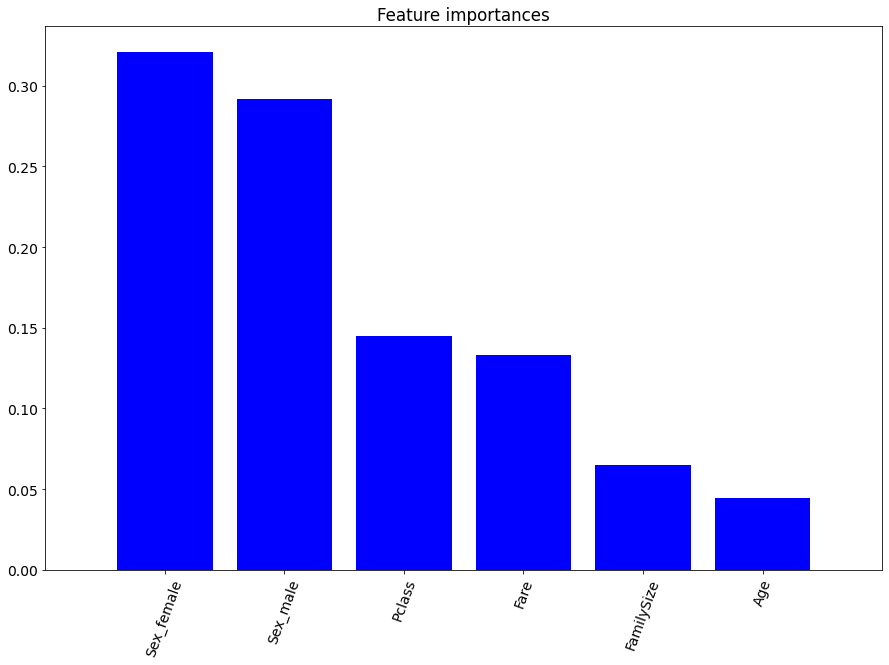

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=3,criterion='entropy')
rf_clf.fit(X_train, y_train)
y_pred=rf_clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(rf_clf, recovered_feat_names, X_train)

In [119]:
f1_scores=np.ndarray([15,15])
n_estimators=np.array(range(1,300,20))
max_depths=np.array(range(1,30,2))
for i, max_depth in enumerate(max_depths):
  for j, n_estimator in enumerate(n_estimators):
    rf_clf = RandomForestClassifier(max_depth=max_depth,criterion='entropy',n_estimators=n_estimator)
    scores = cross_val_score(
      tree,     # Модель для оценки
      X_data,          # Данные для обучения
      y_data,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
    )
    f1_scores[i,j]=scores.mean();
table=pd.DataFrame(data=f1_scores,columns=n_estimators,index=max_depths)
table

,1,21,41,61,81,101,121,141,161,181,201,221,241,261,281
1,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
3,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
5,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
7,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
9,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
11,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
13,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
15,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
17,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808
19,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808,0.794808


судя по результатам количество оценок и максимальная глубина не сильно (никак) влияют на итоговую оценку работы модели.

#поиск лучших параметров через GridSearchCV

In [181]:
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier( )
parameters = {
    'max_depth': [1, 2, 4, 5, 7,9,11],
    'n_estimators': [1, 5, 10, 20, 40,60,80,100,120],
    'criterion': ['gini','entropy'],
}

grid_search = GridSearchCV(
    # модель
    estimator=rf_clf,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_grid=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 80}
0.8067058693699283


применение GridSearchCV позволило найти более лучшие параметры для модели дерева, чем простая кросс-валидация

#поиск лучших параметров через RandomizedSearchCV

In [127]:
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier( )
parameters = {
    'max_depth': [1, 2, 4, 5, 7,9,11],
    'n_estimators': [1, 5, 10, 20, 40,60,80,100,120],
    'criterion': ['gini','entropy'],
}

rand_search = RandomizedSearchCV(
    # модель
    estimator=rf_clf,                   
    # сетка параметров
    #   может быть объектом dict 
    #   или list с несколькими dict внутри (несколько сеток)
    param_distributions=parameters,              
    # кол-во фолдов для CV
    cv=5,                               
    # метрика для оценки - используем F1 
    scoring='f1_macro',   
)

rand_search.fit(X_train, y_train)
print(rand_search.best_params_)
print(rand_search.best_score_)

{'n_estimators': 100, 'max_depth': 5, 'criterion': 'entropy'}
0.8043630851567098


RandomizedSearchCV дал результат хуже даже после нескольких перезапусков.


Сравним работу лучших моделей дерева и леса на тестовой выборке.

In [128]:
rf_clf = RandomForestClassifier(max_depth=7,criterion='gini',n_estimators=100)
rf_clf.fit(X_train, y_train)
y_pred=rf_clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
tree = DecisionTreeClassifier(max_depth=3,criterion='entropy')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7559055118110236
f1_score=0.7301587301587301


не тестовой выборке модель леса, как и предполагалось, дала лучший результат по f1 оценке.

#определение самых информативных признаков

In [172]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
df = pd.read_csv(URL)
df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
isAlone=list();
for pers in df['FamilySize']:
  if pers==1: isAlone.append(1);
  else: isAlone.append(0);
df['isAlone'] = isAlone
discr1 = KBinsDiscretizer(
    n_bins=10,
    encode='ordinal',
)

categorical_features = ['Sex', 'Embarked','isAlone']
numeric_features = ['Pclass','Age', 'Fare','SibSp',	'Parch','FamilySize']

categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

numeric_transformer = SimpleImputer(strategy='median')
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)
y_data = df['Survived']

In [173]:
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFE(estimator=estimator,n_features_to_select=7, step=1)
selector = selector.fit(X_data, y_data)
top7=selector.support_
print(selector.support_)
print(selector.ranking_)
selector = RFE(estimator=estimator,n_features_to_select=5, step=1)
selector = selector.fit(X_data, y_data)
top5=selector.support_
print(selector.support_)
print(selector.ranking_)

[ True  True False False False  True  True False False False  True  True
  True]
[1 1 5 3 4 1 1 2 6 7 1 1 1]
[ True  True False False False  True  True False False False  True False
 False]
[1 1 7 5 6 1 1 4 8 9 1 3 2]


In [174]:
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)

лучшие признаки:

In [175]:
print(np.array(recovered_feat_names)[top5])
print(np.array(recovered_feat_names)[top7])
print(recovered_feat_names)

['Sex_female' 'Sex_male' 'isAlone_0' 'isAlone_1' 'SibSp']
['Sex_female' 'Sex_male' 'isAlone_0' 'isAlone_1' 'SibSp' 'Parch'
 'FamilySize']
['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'isAlone_0', 'isAlone_1', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']


In [176]:
TRAIN_RATIO = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)
X_test7=X_test[:,top7]
X_test5=X_test[:,top5]
X_train7=X_train[:,top7]
X_train5=X_train[:,top5]

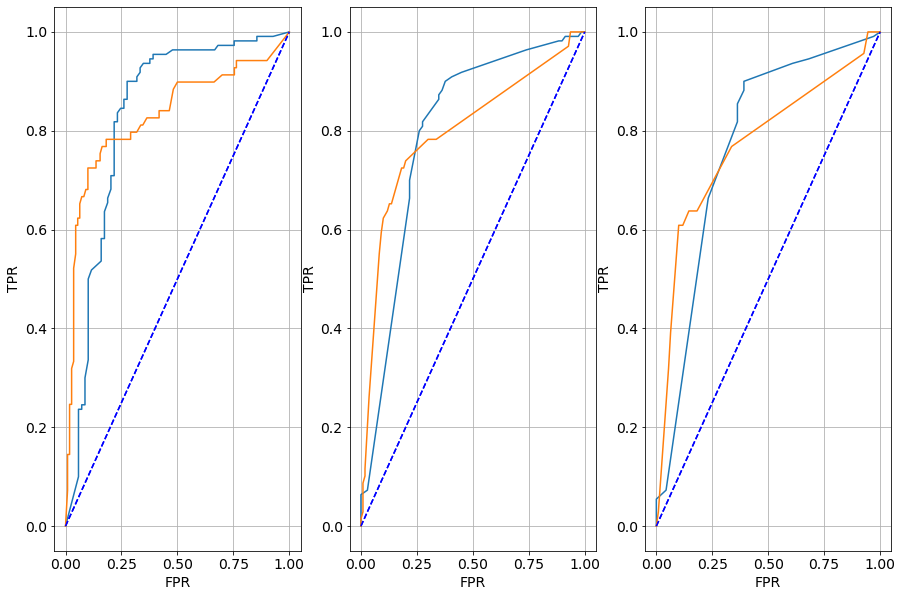

In [178]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
diag_values = np.array([
        [0, 0],
        [1, 1],
    ])

rf_clf=RandomForestClassifier()
rf_clf.fit(X_train,y_train)
y_pred_proba = rf_clf.predict_proba(X_test)
plt.subplot(131)
for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
rf_clf=RandomForestClassifier()
rf_clf.fit(X_train7,y_train)
y_pred_proba = rf_clf.predict_proba(X_test7)
plt.subplot(132)
for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
rf_clf=RandomForestClassifier()
rf_clf.fit(X_train5,y_train)
y_pred_proba = rf_clf.predict_proba(X_test5)
plt.subplot(133)
for i in range (2):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,i],pos_label=i)
    plt.plot(fpr, tpr)
    plt.plot(diag_values[:,0], diag_values[:,1], 'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)

- Какой метод оценки модели лучше использовать в данной работе? Разделение на обучение/тест или кросс-валидация? Можно/нужно ли применять их вместе?
Как оказалось в данном случае использовать лучше кросс-валидацию. Причем лучше методику GridSearchCV.
- За что отвечают параметры `max_depth` и `n_estimators` в модели случайных лесов? Как они влияют на работу модели?
max_depth - это максимальная глубина (величина(число узлов)) каждо дерева леса. n_estimators - это число таких деревьев в лесу. 
- В чем отличие GridSearch от RandomSearch?
В RandomSearch в отличие от GridSearchCV, не все значения предложенных  параметров опробуются, а только фиксированное из количество выбирается из заданных распределений. Количество задается параметром n_iter.
- Как влияет стандартизация признаков на работу модели леса?
Фактически стандартизация признаков не оказала пости никакого влияния на результаты работы модели.
- Что такое "важность признака"? Есть ли аналоги показателя в моделях линейной и логистической регрессии?
В моем понимании важность признака является отображением его веса в линейной или логистической регрессии. и соответственно если она много меньше других, то от такого признака можно избавиться 